In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.metrics import mean_squared_error as mse
import joblib

# Predicting if FIFA players are over or undervalued
We will look at data ('fifa.csv') from over 18000 FIFA players (from the EA sports vidoe game) and predict if they are over or undervalued. Each player has a 'Wage' and a 'Value'. We will consider a player undervalued if their ratio 'Wage' / 'Value' is less than the median of 'Wage' / 'Value' over the dataset.

# Tasks
1. Remove the Euro symbols, and letters from the 'Wage' and 'Value' columns.
2. Define a feature 'Wage_Value_Ratio' as the ratio of 'Wage'/'Value' and find the median of 'Wage_Value_Ratio'. 
3. Define a new feature 'Undervalued' to be 1 if 'Wage_Value_Ratio' is less than the median and 0 otherwise.
4. Drop the columns 'Wage', 'Value', 'Wage_Value_Ratio', 'Name', and 'Club'.
5. Feature engineering (You can use a pipeline for this and the model training):
   1. For the numerical columns, impute with the mean to deal with the missing values and then scale.
   2. For categorical columns, impute with a new category 'Unknown' and then use one-hot encoding.
   3. Use PolynomialFeatures() to create polynomial features and interaction terms.
   4. You can experiment with SelectKBest if you want to try dropping some features.
6. Train and test a random forest model. Look at feature importances.
7. SVC grid search: Define a grid of some values for 'C' and ['linear', 'poly', 'rbf'] for 'kernel'. Use gridsearchCV() to find the best set of hyperparameters. 
8. What were the most important features? Which model tested better: random forest or SVC?

In [12]:
fifa = pd.read_csv('fifa.csv')
fifa

,Name,Age,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Weak Foot,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,94,94,FC Barcelona,€110.5M,€565K,Left,5.0,4.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,94,94,Juventus,€77M,€405K,Right,5.0,4.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,92,93,Paris Saint-Germain,€118.5M,€290K,Right,5.0,5.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,91,93,Manchester United,€72M,€260K,Right,4.0,3.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,91,92,Manchester City,€102M,€355K,Right,4.0,5.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,J. Lundstram,19,47,65,Crewe Alexandra,€60K,€1K,Right,1.0,2.0,...,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0
18203,N. Christoffersson,19,47,63,Trelleborgs FF,€60K,€1K,Right,1.0,2.0,...,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0
18204,B. Worman,16,47,67,Cambridge United,€60K,€1K,Right,1.0,3.0,...,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0
18205,D. Walker-Rice,17,47,66,Tranmere Rovers,€60K,€1K,Right,1.0,3.0,...,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0


# 1-4

In [20]:
# 1. Remove the Euro symbols, and letters from the 'Wage' and 'Value' columns.
def delete_euro(x):
    if pd.isna(x):
        s = None
    else:
        s = str(x).replace('€', '')

    if s is None:
        result = np.nan
    elif s.endswith('M'):
        result = float(s[:-1]) * 1000000
    elif s.endswith('K'):
        result = float(s[:-1]) * 1000
    else:
        result = float(s)

    return result

fifa['Wage'] = fifa['Wage'].apply(delete_euro)
fifa['Value'] = fifa['Value'].apply(delete_euro)

# 2. Define a feature 'Wage_Value_Ratio' as the ratio of 'Wage'/'Value' and find the median of 'Wage_Value_Ratio'
fifa['Wage_Value_Ratio'] = fifa['Wage'] / fifa['Value']
median_ratio = fifa['Wage_Value_Ratio'].median()
print('Median Wage/Value ratio:', median_ratio)

# 3. Define a new feature 'Undervalued' to be 1 if 'Wage_Value_Ratio' is less than the median and 0 otherwise
# Comparison returns boolean then converts it into integer
fifa['Undervalued'] = (fifa['Wage_Value_Ratio'] < median_ratio).astype(int)

# 4. Drop the columns 'Wage', 'Value', 'Wage_Value_Ratio', 'Name', and 'Club'
df = fifa.drop(columns=['Wage','Value','Wage_Value_Ratio','Name','Club'])


Median Wage/Value ratio: 0.004705882352941176


In [19]:
df

,Age,Overall,Potential,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Undervalued
0,31,94,94,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,0
1,33,94,94,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,0
2,26,92,93,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,1
3,27,91,93,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,1
4,27,91,92,Right,4.0,5.0,4.0,High/ High,Normal,RCM,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,Right,1.0,2.0,2.0,Medium/ Medium,Lean,CM,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,0
18203,19,47,63,Right,1.0,2.0,2.0,Medium/ Medium,Normal,ST,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,0
18204,16,47,67,Right,1.0,3.0,2.0,Medium/ Medium,Normal,ST,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,0
18205,17,47,66,Right,1.0,3.0,2.0,Medium/ Medium,Lean,RW,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,0


# 5

In [24]:
X = df.drop('Undervalued', axis=1)
y = df['Undervalued']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [30]:
numerical_features   = ['Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Jersey Number', 
                        'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 
                        'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 
                        'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                        'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 
                        'GKPositioning', 'GKReflexes']
categorical_features = ['Preferred Foot', 'Work Rate', 'Body Type', 'Position']


In [31]:
'''
5. Feature engineering (You can use a pipeline for this and the model training):
    A. For the numerical columns, impute with the mean to deal with the missing values and then scale.
    B. For categorical columns, impute with a new category 'Unknown' and then use one-hot encoding.
    C. Use PolynomialFeatures() to create polynomial features and interaction terms.
'''
# 5. Feature engineering pipelines
# 5a. For the numerical columns, impute with the mean to deal with the missing values and then scale.
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 5b. 
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)

In [38]:
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)

In [46]:

# 5c. Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)


X_train_poly = pd.DataFrame(
    poly.fit_transform(X_train_prepared),
    columns=poly.get_feature_names_out(preprocessor.get_feature_names_out())
)
X_test_poly = pd.DataFrame(
    poly.transform(X_test_prepared),
    columns=poly.get_feature_names_out(preprocessor.get_feature_names_out())
)

X_train_poly.head()


,Age,Overall,Potential,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,...,Position_RW^2,Position_RW Position_RWB,Position_RW Position_ST,Position_RW Position_Unknown,Position_RWB^2,Position_RWB Position_ST,Position_RWB Position_Unknown,Position_ST^2,Position_ST Position_Unknown,Position_Unknown^2
0,-1.313680,-1.629737,-1.193589,-0.286848,0.079012,-0.472002,0.544495,-0.091976,0.075114,-0.826447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.041268,1.410382,0.763599,-0.286848,0.079012,0.857092,-0.091107,0.889502,1.153640,0.785044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.029163,-0.037294,-0.378094,-0.286848,0.079012,-0.472002,0.290254,-1.346086,1.102281,0.785044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.469440,0.541777,-0.214995,-0.286848,0.079012,-0.472002,-0.663149,-1.073454,1.461790,1.475683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.313680,-1.774505,-0.704292,-0.286848,0.079012,-0.472002,0.226694,-0.419135,-0.233036,-0.135808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6

In [51]:
# 6. Train and test a Random Forest model; inspect feature importances
rf_classifier = RandomForestRegressor(n_estimators=100, random_state=42)

rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('poly', poly),
    ('rf', rf_classifier)
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Overall',
                                                   'Potential',
                                                   'International Reputation',
                                                   'Weak Foot', 'Skill Moves',
                                                   'Jersey Number', 'Crossing',
                                                   'Finishing',
                                                   'HeadingAccuracy',
                                                   'ShortPassing', 'Volleys',
                                                   'Dribbling', 'Curve',
                                                   'FKAccuracy', 'LongPassing',
                                                   'Ba...
                                                   'Interceptions',
                                                   'Positioning', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Preferred Foot',
                                                   'Work Rate', 'Body Type',
                                                   'Position'])],
                                   verbose_feature_names_out=False)),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('rf', RandomForestRegressor(random_state=42))])

Random Forest test accuracy: 0.25553028934029864


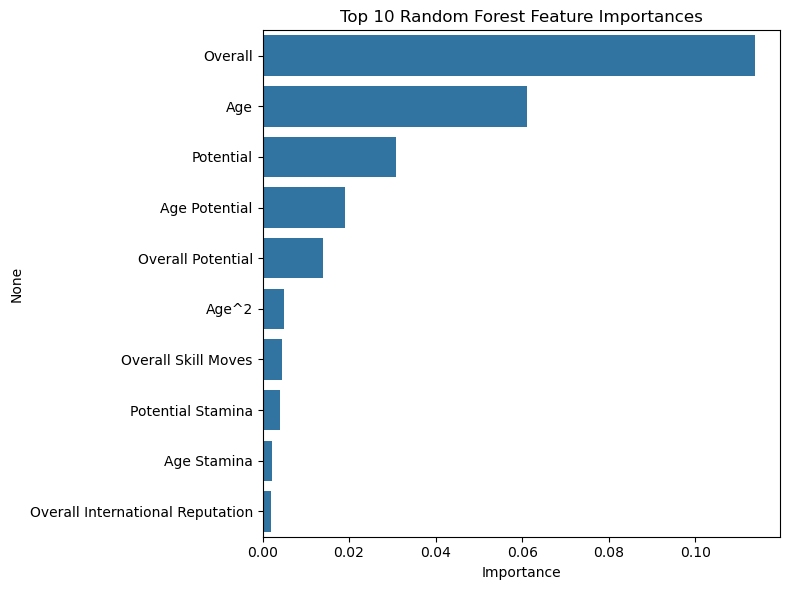

In [52]:
rf_acc = rf_pipeline.score(X_test, y_test)
print('Random Forest test accuracy:', rf_acc)



poly_feats = poly.get_feature_names_out(preprocessor.get_feature_names_out())

# get importances
importances = rf_pipeline.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=poly_feats).sort_values(ascending=False)

# plot top 10
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.iloc[:10].values, y=feat_imp.iloc[:10].index)
plt.title('Top 10 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [57]:
rf_results = {
    'pipeline': rf_pipeline,            
    'test_accuracy': rf_acc,           
    'feature_names': poly_feats,       
    'feature_importances': feat_imp     
}

joblib.dump(rf_results, 'rf_results.joblib')

['rf_results.joblib']

# 7 & 8

## NOTE: scikit-learn-intelex does not work on Macs, must run on Windows(Beauty)

In [62]:
!pip install scikit-learn-intelex

ERROR: Could not find a version that satisfies the requirement scikit-learn-intelex (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for scikit-learn-intelex


In [59]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC

ModuleNotFoundError: No module named 'sklearnex'

In [53]:
# 7. SVC grid search over C and kernel
svc_pipe = Pipeline([
    ('preproc', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('svc', SVC())
])
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear','poly','rbf']
}
gs = GridSearchCV(svc_pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
gs.fit(X_train, y_train)
y_pred_svc = gs.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred_svc)
print(f"7. Best SVC params: {gs.best_params_}")
print(f"7. SVC test accuracy: {svc_acc:}")


KeyboardInterrupt: 

In [ ]:

# 8. Compare results
print(f"8. Random Forest vs. SVC: {rf_acc:} vs. {svc_acc:}")
print("8. RF top features:")
print(feat_imp)